In [1]:
# If running locally and ART isn't installed, uncomment:
# !pip install adversarial-robustness-toolbox

import os, json, time, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models # type: ignore
import seaborn as sns

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer

# Folders
BASE_DIR = "secure_ai_mnist"
FIG_DIR  = os.path.join(BASE_DIR, "figures")
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

np.random.seed(42)
tf.random.set_seed(42)


/Users/kartekeyaan/Chonky_folder/MNISTass/mnist-secure-ai-env/lib/python3.9/site-packages/art/estimators/certification/__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [2]:
FGSM_EPS = 0.25        # try 0.1–0.3 to see robustness change
ADV_EPOCHS = 5
BATCH_SIZE = 128


In [3]:
# Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32")/255.0)[..., None]
x_test  = (x_test.astype("float32")/255.0)[..., None]

# Load baseline model (.keras preferred, fallback to .h5)
keras_path = os.path.join(MODEL_DIR, "baseline_cnn.keras")
h5_path    = os.path.join(MODEL_DIR, "baseline_cnn.h5")
if os.path.exists(keras_path):
    baseline_model = models.load_model(keras_path)
elif os.path.exists(h5_path):
    baseline_model = models.load_model(h5_path)
else:
    raise FileNotFoundError(
        f"Baseline model not found.\nExpected at:\n  {keras_path}\n  or {h5_path}\n"
        "Run your baseline training first."
    )

baseline_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"])

print("Baseline model loaded.")


2025-11-24 11:22:04.333349: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-24 11:22:04.333374: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-24 11:22:04.333380: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-24 11:22:04.333392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-24 11:22:04.333399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Baseline model loaded.


In [4]:
classifier = KerasClassifier(model=baseline_model, clip_values=(0.0,1.0), use_logits=False)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=FGSM_EPS)
print("ART classifier and FGSM ready.")


ART classifier and FGSM ready.


2025-11-24 11:22:05.112137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


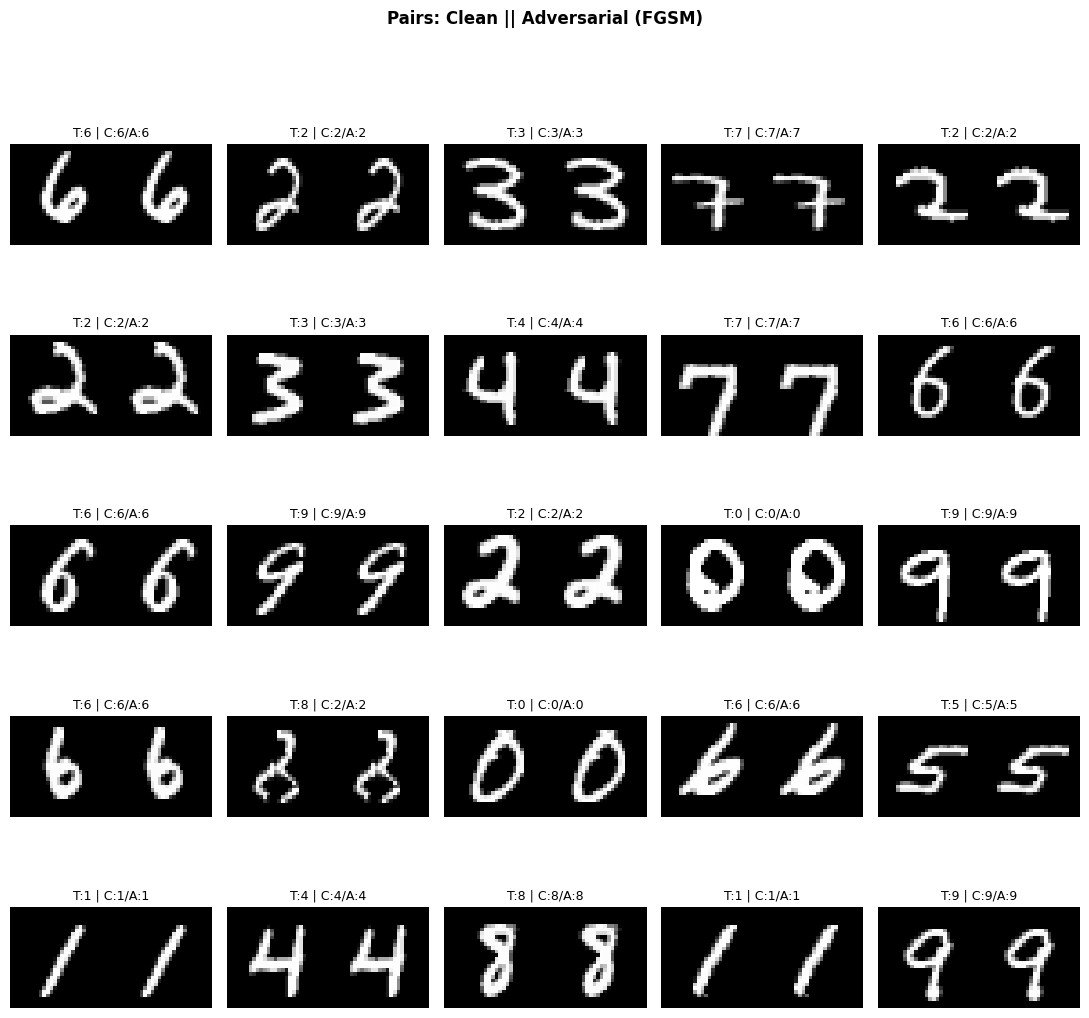

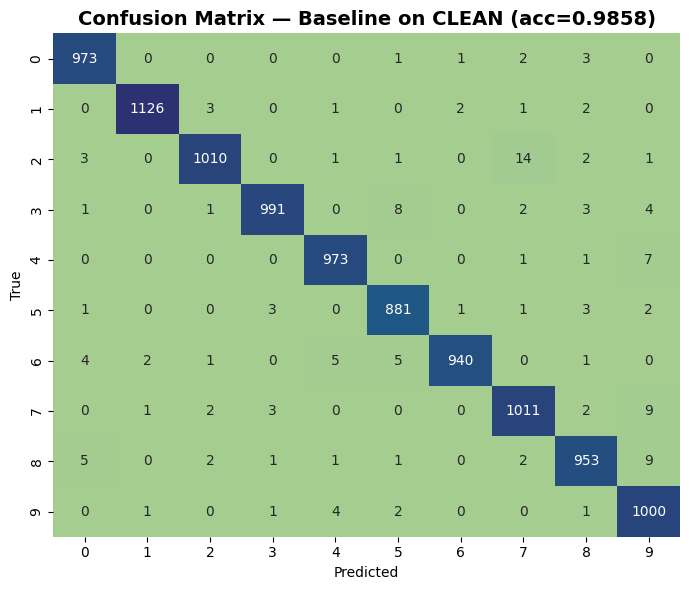

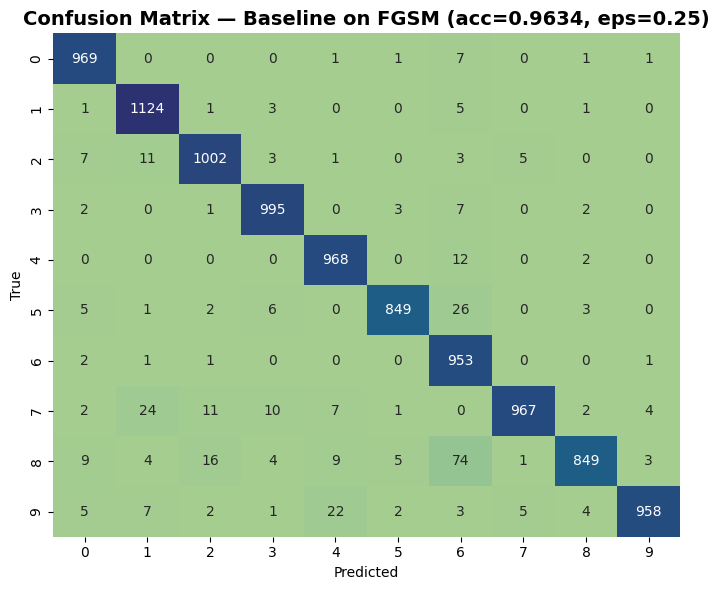

✅ FGSM done
{
  "attack": "FGSM",
  "eps": 0.25,
  "generation_time_sec": 3.7258927822113037,
  "baseline_clean_accuracy": 0.98580002784729,
  "baseline_adversarial_accuracy": 0.9634
}


In [5]:
def plot_confusion_matrix(cm, title, save_path):
    fig, ax = plt.subplots(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False, ax=ax)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.tight_layout()
    fig.savefig(save_path, bbox_inches="tight")
    plt.show()

def show_examples(x_clean, x_adv, y_true, y_pred_clean, y_pred_adv, save_path, n=25):
    n = min(n, x_clean.shape[0])
    idx = np.random.choice(x_clean.shape[0], n, replace=False)
    cols = 5
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.2, rows*2.2))
    axes = np.array(axes).reshape(rows, cols)

    for k, ax in enumerate(axes.ravel()):
        ax.axis("off")
        if k >= n: continue
        i = idx[k]
        clean = x_clean[i].squeeze()
        adv   = x_adv[i].squeeze()
        panel = np.concatenate([clean, adv], axis=1)
        ax.imshow(panel, cmap="gray")
        ax.set_title(f"T:{y_true[i]} | C:{y_pred_clean[i]}/A:{y_pred_adv[i]}", fontsize=9)

    plt.suptitle("Pairs: Clean || Adversarial (FGSM)", fontsize=12, fontweight="bold")
    plt.tight_layout(rect=[0,0,1,0.96])
    fig.savefig(save_path, bbox_inches="tight")
    plt.show()

# Clean performance
loss_clean, acc_clean = baseline_model.evaluate(x_test, y_test, verbose=0)

# Generate adversarial test set
t0 = time.time()
x_test_adv = attack_fgsm.generate(x=x_test)
t1 = time.time()
gen_time = t1 - t0

# Predictions
y_pred_clean = np.argmax(baseline_model.predict(x_test,     verbose=0), axis=1)
y_pred_adv   = np.argmax(baseline_model.predict(x_test_adv, verbose=0), axis=1)

acc_adv = float(np.mean(y_pred_adv == y_test))
cm_clean = confusion_matrix(y_test, y_pred_clean)
cm_adv   = confusion_matrix(y_test, y_pred_adv)

# Save example grid & confusion matrices
show_examples(
    x_clean=x_test, x_adv=x_test_adv, y_true=y_test,
    y_pred_clean=y_pred_clean, y_pred_adv=y_pred_adv,
    save_path=os.path.join(FIG_DIR, "fgsm_examples.png"), n=25
)
plot_confusion_matrix(cm_clean,
    title=f"Confusion Matrix — Baseline on CLEAN (acc={acc_clean:.4f})",
    save_path=os.path.join(FIG_DIR, "fgsm_cm_clean_baseline.png")
)
plot_confusion_matrix(cm_adv,
    title=f"Confusion Matrix — Baseline on FGSM (acc={acc_adv:.4f}, eps={FGSM_EPS})",
    save_path=os.path.join(FIG_DIR, "fgsm_cm_adv_baseline.png")
)

# JSON metrics
fgsm_metrics = {
    "attack": "FGSM",
    "eps": FGSM_EPS,
    "generation_time_sec": gen_time,
    "baseline_clean_accuracy": float(acc_clean),
    "baseline_adversarial_accuracy": float(acc_adv)
}
with open(os.path.join(BASE_DIR, "fgsm_metrics.json"), "w") as f:
    json.dump(fgsm_metrics, f, indent=2)

print("✅ FGSM done")
print(json.dumps(fgsm_metrics, indent=2))


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Saved adv-trained model to: secure_ai_mnist/models/adv_trained_cnn.keras


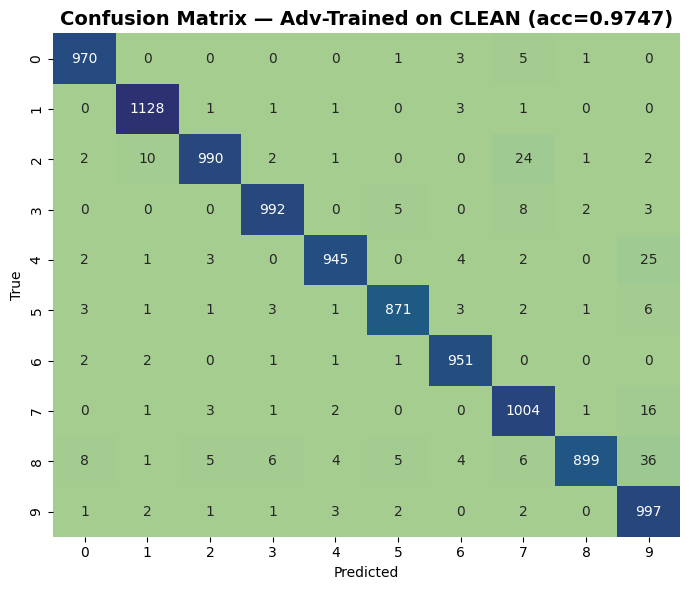

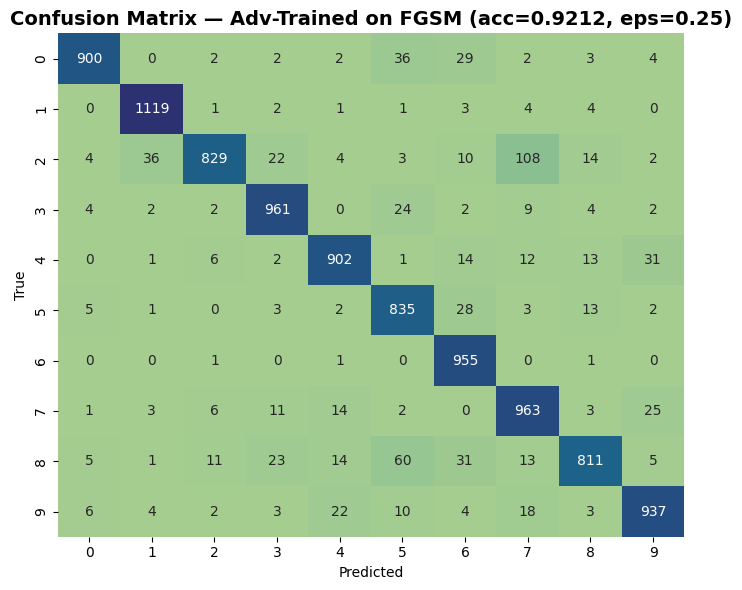

✅ Adversarial training done
{
  "attack": "FGSM",
  "eps": 0.25,
  "advtrain_epochs": 5,
  "advtrain_batch_size": 128,
  "advtrain_time_sec": 94.08724999427795,
  "advtrained_clean_accuracy": 0.9746999740600586,
  "advtrained_adversarial_accuracy": 0.9212,
  "saved_model": "secure_ai_mnist/models/adv_trained_cnn.keras"
}


In [6]:
# Recreate a model to adversarially train (start from baseline weights)
adv_model = models.load_model(keras_path if os.path.exists(keras_path) else h5_path)
adv_model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

adv_classifier = KerasClassifier(model=adv_model, clip_values=(0.0,1.0), use_logits=False)

trainer = AdversarialTrainer(classifier=adv_classifier, attacks=attack_fgsm, ratio=0.5)

t0 = time.time()
trainer.fit(x_train, y_train, nb_epochs=ADV_EPOCHS, batch_size=BATCH_SIZE)
t1 = time.time()
advtrain_time = t1 - t0

adv_model_path = os.path.join(MODEL_DIR, "adv_trained_cnn.keras")
adv_model.save(adv_model_path)
print("Saved adv-trained model to:", adv_model_path)

# Evaluate on clean
loss_clean_adv, acc_clean_adv = adv_model.evaluate(x_test, y_test, verbose=0)
y_pred_clean_adv = np.argmax(adv_model.predict(x_test, verbose=0), axis=1)
cm_clean_adv = confusion_matrix(y_test, y_pred_clean_adv)

# Re-generate FGSM against adv-trained model
adv_classifier_for_test = KerasClassifier(model=adv_model, clip_values=(0.0,1.0), use_logits=False)
attack_fgsm_for_test = FastGradientMethod(estimator=adv_classifier_for_test, eps=FGSM_EPS)
x_test_adv2 = attack_fgsm_for_test.generate(x=x_test)

y_pred_adv2 = np.argmax(adv_model.predict(x_test_adv2, verbose=0), axis=1)
acc_adv2 = float(np.mean(y_pred_adv2 == y_test))
cm_adv2 = confusion_matrix(y_test, y_pred_adv2)

# Save confusion matrices
def save_cm(cm, title, fname):
    fig, ax = plt.subplots(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False, ax=ax)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.tight_layout()
    fig.savefig(os.path.join(FIG_DIR, fname), bbox_inches="tight")
    plt.show()

save_cm(cm_clean_adv, f"Confusion Matrix — Adv-Trained on CLEAN (acc={acc_clean_adv:.4f})",
        "fgsm_cm_clean_advtrained.png")
save_cm(cm_adv2, f"Confusion Matrix — Adv-Trained on FGSM (acc={acc_adv2:.4f}, eps={FGSM_EPS})",
        "fgsm_cm_adv_advtrained.png")

# JSON metrics
advtrain_metrics = {
    "attack": "FGSM",
    "eps": FGSM_EPS,
    "advtrain_epochs": ADV_EPOCHS,
    "advtrain_batch_size": BATCH_SIZE,
    "advtrain_time_sec": advtrain_time,
    "advtrained_clean_accuracy": float(acc_clean_adv),
    "advtrained_adversarial_accuracy": float(acc_adv2),
    "saved_model": adv_model_path
}
with open(os.path.join(BASE_DIR, "advtrain_metrics.json"), "w") as f:
    json.dump(advtrain_metrics, f, indent=2)

print("✅ Adversarial training done")
print(json.dumps(advtrain_metrics, indent=2))


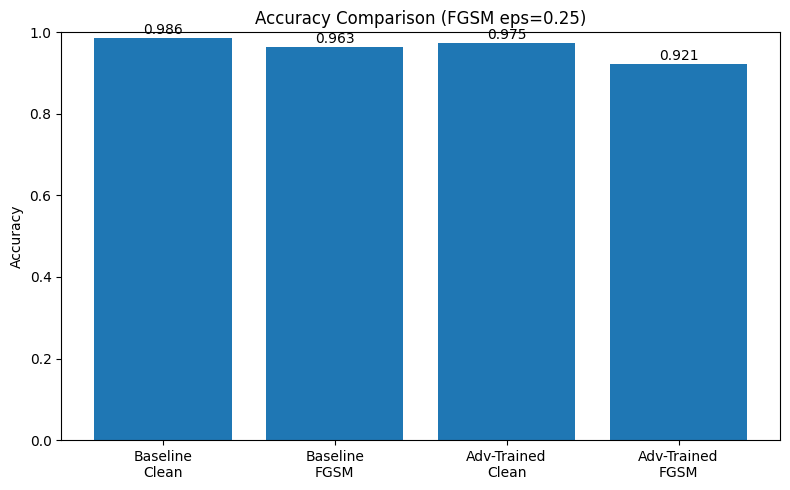

📊 Figures & JSON saved to: secure_ai_mnist


In [ ]:
labels = ["Baseline\nClean", "Baseline\nFGSM", "Adv-Trained\nClean", "Adv-Trained\nFGSM"]
values = [float(fgsm_metrics["baseline_clean_accuracy"]),
          float(fgsm_metrics["baseline_adversarial_accuracy"]),
          float(advtrain_metrics["advtrained_clean_accuracy"]),
          float(advtrain_metrics["advtrained_adversarial_accuracy"])]

fig = plt.figure(figsize=(8,5))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title(f"Accuracy Comparison (FGSM eps={FGSM_EPS})")
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fgsm_accuracy_comparison.png"), bbox_inches="tight")
plt.show()

print("📊 Figures & JSON saved to:", BASE_DIR)